In [18]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import pickle

%config InlineBackend.figure_formats = {'png', 'retina'}

In [30]:
%%html
<link rel="stylesheet" type="text/css" href="./custom.css">

In [19]:
mpl.rcParams['font.family'] = 'MigMix 1M'
np.random.rand(0) 
#%%
def pickle_load(path):
    '''
    調整したハイパーパラメータファイルのロード
    '''
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data


def load_train_data():
    '''
    学習データの作成
    '''
    start_target = datetime.date(2019, 3, 1)
    # Kセットのデータを作成
    K = 11
    df = pd.DataFrame()
    for k in range(K):
        # 予測対象の始点からkヶ月前
        target_month = start_target - relativedelta(months=k)
        target_str = target_month.strftime('%Y.%m.%d')
        if os.path.isfile(os.path.join(train_data_dir, 'train_{}.csv'.format(target_str))):
            df = pd.concat([df,pd.read_csv(os.path.join(train_data_dir, 'train_{}.csv'.format(target_str)))])
    X = df.drop(['顧客ID','案件ID','利用区分'], axis=1)
    y = df['利用区分']
    return X, y


def load_test_data():
    '''
    テストデータの作成
    '''
    start_target = datetime.date(2020, 3, 1)
    # Kセットのデータを作成
    K = 12
    df = pd.DataFrame()
    for k in range(K):
        # 予測対象の始点からkヶ月前
        target_month = start_target - relativedelta(months=k)
        target_str = target_month.strftime('%Y.%m.%d')
        if os.path.isfile(os.path.join(train_data_dir, 'train_{}.csv'.format(target_str))):
            df = pd.concat([df,pd.read_csv(os.path.join(train_data_dir, 'train_{}.csv'.format(target_str)))])
    X = df.drop(['顧客ID','案件ID','利用区分'], axis=1)
    y = df['利用区分']
    return X, y


def train_model(params):
    '''
    調整したハイパーパラメータでのモデルの学習
    '''
    X, y = load_train_data()
    rfc = RandomForestClassifier(**params, class_weight="balanced", n_estimators = 300, random_state=0)
    rfc.fit(X, y)
    return rfc


def default_model():
    '''
    既定のハイパーパラメータでのモデルの学習
    '''
    X, y = load_train_data()
    rfc = RandomForestClassifier(class_weight="balanced", random_state=0)
    rfc.fit(X, y)
    return rfc


def test_model(rfc):
    '''
    APの計算とPR曲線の可視化
    '''
    X, y = load_test_data()
    disp = plot_precision_recall_curve(rfc, X, y)
    plt.legend(loc='upper right')
    return


def visualize_feature_importance():
    '''
    変数重要度の可視化
    '''
    X, y = load_train_data()
    importances = rfc.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]
    names = list(X.columns)
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), list(np.array(names)[indices]),rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    return


def write_summary(rfc):
    '''
    閾値決定のための予測サマリファイルを出力
    '''
    # テストデータのロード
    X, y = load_test_data()
    # 閾値とそれに対する適合率，再現率を出力
    y_preds = rfc.predict_proba(X).T[1]
    print('AP: {}'.format(average_precision_score(y, y_preds)))
    precision, recall, thresholds = precision_recall_curve(y, y_preds)
    # 閾値以上のときの総契約数，解約数を算出
    ans_list = []
    cnt_list = []
    for i, score in enumerate(sorted(thresholds)):
        cnt = 0
        ans = 0
        for y_ans, y_pred in zip(y, y_preds):
            if y_pred >= score:
                cnt+=1
                if y_ans == 1:
                    ans+=1
        ans_list.append(ans)
        cnt_list.append(cnt)
    # サマリファイルの出力
    df_result = pd.concat([pd.DataFrame(thresholds), 
                pd.DataFrame(cnt_list),
                pd.DataFrame(ans_list),
                pd.DataFrame(precision), 
                pd.DataFrame(recall)],axis=1)
    df_result.columns = ['thresholds', 'all', 'cancel', 'presicion', 'recall']
#     df_result.drop_duplicates(subset='cancel', inplace=True)
    df_result.to_csv('result/result.csv', index=None)
    return 

In [20]:
#%%
# 入力変数のディレクトリ設定
# train_data_dir = './output/'
train_data_dir = './output_bk3/'

In [21]:
# 調整したハイパーパラメータのロード
params = pickle_load('param_files/rfc_param_3.pickle')

In [22]:
#%%
# 調整したハイパーパラメータでのモデルの学習
rfc = train_model(params)

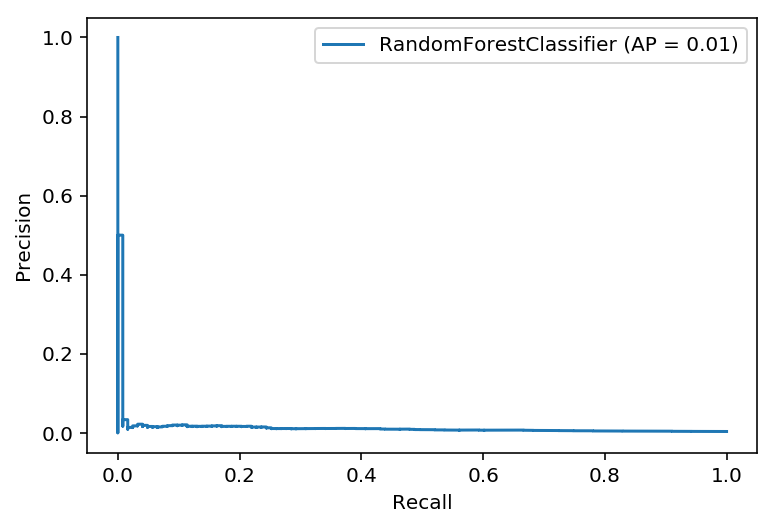

In [23]:
#%%
# モデルの評価
test_model(rfc)

Feature ranking:
1. feature ﾛｸﾞｲﾝﾕｰｻﾞｰ数(前月)_0 (0.116116)
2. feature 申請書累計_1-0_diff (0.098437)
3. feature 現在ユーザ数 (0.092391)
4. feature 操作ﾛｸﾞ(前月)_1 (0.086776)
5. feature ﾛｸﾞｲﾝﾕｰｻﾞｰ数(前月)_1 (0.082218)
6. feature 社員数_0 (0.076502)
7. feature 申請書累計_2-1_diff (0.073824)
8. feature 操作ﾛｸﾞ(前月)_2 (0.070628)
9. feature 操作ﾛｸﾞ(前月)_0 (0.067009)
10. feature 申請書累計_3-2_diff (0.064803)
11. feature ﾛｸﾞｲﾝﾕｰｻﾞｰ数(前月)_2 (0.061220)
12. feature 社員数_2 (0.058458)
13. feature 社員数_1 (0.051619)


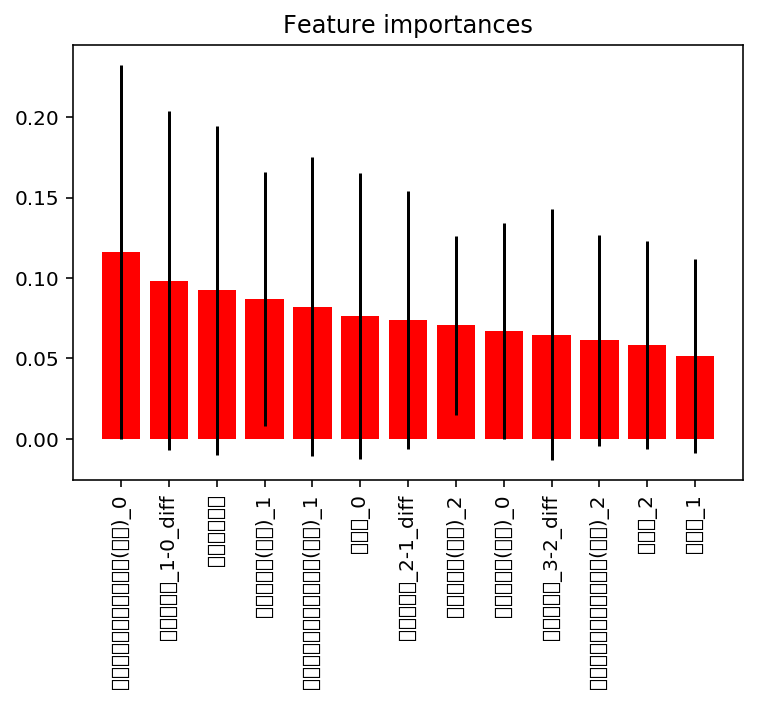

In [24]:
#%%
# 学習されたモデルでの特徴量重要度の可視化
visualize_feature_importance()

In [25]:
# #%%
# # デフォルトのハイパーパラメータでのモデルの学習
# rfc = default_model()

In [43]:
X, y = load_test_data()
y.value_counts()

0    36611
1      123
Name: 利用区分, dtype: int64

In [44]:
#%%
# サマリファイルの出力
write_summary(rfc)

AP: 0.01359749985771767


## 進捗報告

2020/6/5

### アジェンダ
1. 前回MTG振り返り
    - 1.1. 契約年度による解約率集計
    - 1.2. ラクス様指定13変数の平均値比較
    - 1.3. アウトプットイメージ
2. 進捗状況報告
    - 2.1. 解約予測の期間
    - 2.2. データ準備
    - 2.3. モデルの評価
    - 2.4. 閾値の評価
3. 検討事項

### 1. 前回MTG振り返り
1.1.  契約年度による解約率集計<br>
<br>
<span style="color: whitesmoke; ">1.2.  ラクス様指定13変数の平均値比較</span><br>
<br>
<span style="color: whitesmoke; ">1.3.  アウトプットイメージ</span><br>

### 1.1. 契約年度による解約率集計
<div style="text-align: center;">
<img src="./image/nendo-kaiyakuritsu.png" title="nendo_kaiyaku" width="960" height="640" >
</div>

### 1. 前回MTG振り返り
<span style="color: whitesmoke; ">1.1.  契約年度による解約率集計</span><br>
<br>
1.2.  ラクス様指定13変数の平均値比較</span><br>
<br>
<span style="color: whitesmoke; ">1.3.  アウトプットイメージ</span><br>

### 1.2. ラクス様指定13変数の平均値比較
<img src="./image/ave_13.png" title="ave_13" width="960" height="640">

### 1. 前回MTG振り返り
<span style="color: whitesmoke; ">1.1.  契約年度による解約率集計</span><br>
<br>
<span style="color: whitesmoke; ">1.2.  ラクス様指定13変数の平均値比較</span><br>
<br>
1.3.  アウトプットイメージ

### 1.3. アウトプットイメージ
- <span style="color: blue; ">6ヶ月後</span>の解約予測
    - 3ヶ月前にわかっても手遅れの場合がある． 
    - 3ヶ月前だと既にリプレイス準備が進んでいる可能性が高い．
- <span style="color: blue; ">3段階表示</span>
     - 運用を考えた際, 複雑なスコアが出ても使いづらい．
     - ○△×くらいのイメージ, 表現方法は別途検討．

###  2. 進捗報告
<span style="color: black; ">2.1. 解約予測の期間</span><br>
<br>
<span style="color:  black; ">2.2. データ準備</span><br>
<br>
<span style="color:  black; ">2.3. モデルの評価</span><br>
<br>
<span style="color:  black; ">2.4. 閾値の評価</span>

###  2. 進捗報告
<span style="color: black; ">2.1. 解約予測の期間</span><br>
<br>
<span style="color: whitesmoke; ">2.2. データ準備</span><br>
<br>
<span style="color: whitesmoke; ">2.3. モデルの評価</span><br>
<br>
<span style="color: whitesmoke; ">2.4. 閾値の評価</span>

### 2.1. 解約予測の期間
- <span style="color: blue; ">3ヶ月分</span>のデータを使い, <span style="color: blue; ">6ヶ月後</span>の解約予測のモデルを作成
    - 例) 2019年7月, 2019年8月, 2019年9月のデータを使い，2020年3月の**利用区分**を予測

<br>
<br>

<div style="text-align: center;">
<!-- <font size="4"> -->
    学習データのイメージ
<!-- </font> -->
</div>

| No |2019/5| 2019/6 | 2019/7 | 2019/8 | 2019/9 | 2019/10 | 2019/11 | 2019/12 | 2020/1 | 2020/2 | 2020/3 |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| 1 |-| - | <span style="color: blue; ">●</span> | <span style="color: blue; ">●</span> | <span style="color: blue; ">●</span> | → | → | → | → | → | <span style="color: blue; ">予測</span> |
| 2 |-| <span style="color: blue; ">●</span> | <span style="color: blue; ">●</span> | <span style="color: blue; ">●</span> | → | → | → | → | → | <span style="color: blue; ">予測</span> | - |
| 3 | <span style="color: blue; ">●</span> | <span style="color: blue; ">●</span> | <span style="color: blue; ">●</span> | → | → | → | → | → | <span style="color: blue; ">予測</span> | - | - |
| $\vdots$ |$\vdots$| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

###  2. 進捗報告
<span style="color: whitesmoke; ">2.1. 解約予測の期間</span><br>
<br>
<span style="color: black; ">2.2. データ準備</span><br>
<br>
<span style="color: whitesmoke; ">2.3. モデルの評価</span><br>
<br>
<span style="color: whitesmoke; ">2.4. 閾値の評価</span>

### 2.2. データ準備
<span style="color: blue; ">3パターン</span>のデータセットを利用してモデルを作成

1. ラクス様指定13変数
2. ラクス様指定，指定外も含めた35変数
3. 1., 2.の分析結果をもとに選択した5変数

### 1. ラクス様指定13変数
<div align="center">
        <img src="./image/13_feature.png" title="13_" width="300"　height="200">
</div>

### 2. ラクス様指定，指定外も含めた35変数
- マスタ, 契約時変数， 期間などを追加

<div align="center">
    <img src="./image/35_feature.png" title="35_" width="1000" height="600">
</div>

### 3. 1., 2.の分析結果をもとに選択した5変数
- 変数重要度， かつ汎用的に存在しそうな5変数(13次元)を選択
    - 現在ユーザ数
    - 社員数
    - ログインユーザ数
    - 申請書累計
    - 操作ログ
    
<div align="center">
    <img src="./image/5_feature.png" title="13_" width="1920" height="1080">
</div>

###  2. 進捗報告
<span style="color: whitesmoke; ">2.1. 解約予測の期間</span><br>
<br>
<span style="color:whitesmoke; ">2.2. データ準備</span><br>
<br>
<span style="color:  black; ">2.3. モデルの評価</span><br>
<br>
<span style="color: whitesmoke; ">2.4. 閾値の評価</span>

### 2.3. モデルの評価
- 3パターンの変数を利用したモデル(ランダムフォレスト)を作成
    - 13変数→35変数に増やすことでモデルの性能(平均適合率)が向上
    - 向上要因:増やした変数のなかに有効な変数が含まれていたため
-  35変数の分析結果を考察し，5変数選択することでさらに性能は向上
    - 向上要因:有効な変数に対して詳細なルールを作成できたため
    

<div style="text-align: center;">
<font size="5">
    データセットによる平均適合率の比較
</font>
</div>

| パターン | モデルでの利用変数の説明 | 平均適合率(✳︎1) |
| ---- | ---- | ---- |
| 1 | ラクス様指定の13変数(39次元) | 1.04% |
| 2 | 指定外も含めた35変数(127次元) | 1.07% |
| 3 | 1., 2.の分析結果をもとに選択した5変数(13次元) | 1.12% |

<div style="text-align: right;">
<font size="4">
    (✳︎1) ハイパーパラメータ調整あり
</font>
</div>

###  2. 進捗報告
<span style="color: whitesmoke; ">2.1. 解約予測の期間</span><br>
<br>
<span style="color:whitesmoke; ">2.2. データ準備</span><br>
<br>
<span style="color:  whitesmoke; ">2.3. モデルの評価</span><br>
<br>
<span style="color: black; ">2.4. 閾値の評価</span>

### 2.4. 閾値の評価
[result](https://docs.google.com/spreadsheets/d/10SRnwip-tgDWQq9J6w9esIyCubPjjKFa-HF1ZTBgdcU/edit#gid=254709839)

In [106]:
df = pd.read_csv("./result/result_drop_duplicates.csv", usecols=[0,1,2,3,4])
df.head(10)

thresholds      all  cancel  presicion    recall
0    0.006261  36376.0   123.0   0.003381  1.000000
1    0.006277  36297.0   122.0   0.003361  0.991870
2    0.006540  36025.0   121.0   0.003359  0.983740
3    0.010684  34265.0   120.0   0.003502  0.975610
4    0.015416  33299.0   119.0   0.003574  0.967480
5    0.016984  33106.0   118.0   0.003564  0.959350
6    0.017293  33053.0   117.0   0.003540  0.951220
7    0.021966  32418.0   116.0   0.003578  0.943089
8    0.031297  31556.0   115.0   0.003644  0.934959
9    0.043864  30538.0   114.0   0.003733  0.926829

### 2.4. 閾値の評価
- パターン3のモデルに固定し，下表の5つの閾値パターンを比較
    - -> 上位5%，上位20%と閾値を設定した場合が高/低の値が大きい
    - -> 解約レベル高は低に比べて約7倍，中は低に比べて約3倍
    
<div align="center">
    <img src="./image/thresholds.png" title="13_" width="1920" height="1080">
</div>

### 3. 検討事項

### 3. 検討事項
解約レベル「<span style="color: red; ">高</span>|<span style="color: orange; ">中</span>」の閾値と解約レベル「<span style="color: orange; ">中</span>|<span style="color: blue; ">低</span>」の閾値を 現実のオペレーションを考慮して設定したい．
- 【参考値】 1ヶ月あたりでは約3000契約存在
    - 上位1%: 30契約
    - 上位3%: 90契約
    - 上位5%: 150契約
    - 上位10%: 300契約

### 4. まとめ
1. 3パターンのデータセットを利用してモデル作成した．
    - 5変数(13次元)によるモデルの精度が高かった．
    - 現在ユーザ数，社員数，ログインユーザ数，申請書累計，操作ログ
2. 解約顧客の予測
    - ランダムな予測と比較して，3倍程度予測精度が向上した．
3. 解約レベルの閾値（3段階）をどこにするかを検討した．

### 参考: 重要変数に関するインサイト
1. 申請書累計:申請書が減っていると解約する
2. ログインユーザーと現在ユーザー数(最大アカウント数):
    最大アカウント数が多いにもかかわらず，ログインユーザー数が極端に少ないと解約する
3. ログインユーザー数:ログインユーザー数が極端に減ると解約する
4. 操作ログ:経理処理や管理操作などの操作ログが減っていると解約する
5. 社員数:社員数に比べてログインユーザー数が少ないと解約する

In [1]:
conda install -c conda-forge rise

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
